# Machine Learning Modelling and Prediction

In [2]:
import pandas as pd
import numpy as np
import cv2
import os
from shutil import copyfile

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.preprocessing.image import ImageDataGenerator

/home/diegues/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Defining functions to print wrong predictions for comparison and to create the environment in the machine in order to use images in the models.

In [4]:
def printWrongPreds(preds, targets):
    df = pd.DataFrame()
    images = []
    predictions = []
    targets_ = []
    if(type(preds) == pd.DataFrame):          
        predsClass = preds.idxmax(axis=1)
        targetsClass = targets.idxmax(axis=1)  
        for i in range(0,len(predsClass)):
            if(predsClass[i] != targetsClass[i]):
                images.append(targets.index[i])
                predictions.append(predsClass[i])
                targets_.append(targetsClass[i])
                print('Image:', targets.index[i],'\t\tPrediction:', predsClass[i], '\tTarget:', targetsClass[i])
    else:
        for i in range(0,len(preds)):
            if(preds[i] != targets['level3'][i]):
                images.append(targets.index[i])
                predictions.append(preds[i])
                targets_.append(targets['level3'][i])
                print('Image:', targets.index[i],'\t\tPrediction:', preds[i], '\tTarget:', targets['level3'][i])
    df['image'] = images
    df['prediction'] = predictions
    df['target'] = targets_
    return df

def createDirectoryEnvironment(train_data, train_targets, val_data, val_targets, path):
    trainpath = path + 'train/'
    valpath = path + 'validation/'
    if(os.listdir() == 2):
        return trainpath,valpath
    if(not os.path.exists(trainpath)):
        os.mkdir(trainpath)
    if(not os.path.exists(valpath)):
        os.mkdir(valpath)
        
    classes = train_targets.columns.append(val_targets.columns).drop_duplicates()  
    for c in classes:
        train_class = trainpath + c + '/'
        val_class = valpath + c + '/'
        if(not os.path.exists(train_class)):
            os.mkdir(train_class)
        if(not os.path.exists(val_class)):
            os.mkdir(val_class)
            
    for f in train_data.index.values:
        copyfile(path + '../' + f[:f.find('frame')-1] + '/' + f, trainpath + train_targets.loc[f].idxmax(axis = 1) + '/' + f)
    for f in val_data.index.values:
        copyfile(path + '../' + f[:f.find('frame')-1] + '/' + f, valpath + val_targets.loc[f].idxmax(axis = 1) + '/' + f)
    
    return trainpath, valpath

## Data Import and Train Test split

Here we import the data and process it with one-hot encoding, dropping the columns that did not add relevance to the models. Also, we're predicting (for now) only the level 3 of the EUNIS taxonomy, as the amount of data is still short.

In [5]:
folder_path = "/home/diegues/Desktop/ProcessedImages/"
data = pd.read_csv(folder_path + "sampled_data.csv")
#classes = open(folder_path + "classes.txt", "r").readlines()

filenames = data['filename']
targets = data['level3']

# one-hot encoding
targets_ohe = pd.get_dummies(data['level3'])
#species_ohe = pd.get_dummies(data['species'])

# dealing with NaNs
data = data.drop(['roll', 'pitch', 'level1', 'level2', 'level3', 'level4', 
                  'level5', 'level6', 'AphiaID', 'EunisName', 'EunisCode', 
                  'date', 'timestamp', 'species'],
                 axis = 1)

X = data.groupby('filename').max()
Y_ohe = pd.concat([filenames,targets_ohe], axis = 1).groupby('filename').max()
Y_cat = pd.concat([filenames,targets], axis = 1).groupby('filename').max()

print(pd.value_counts(Y_cat.level3).to_frame().reset_index())

# tts
train_X_ohe, test_X_ohe, train_Y_ohe, test_Y_ohe = train_test_split(X, Y_ohe, test_size = 0.3)
train_X_cat, test_X_cat, train_Y_cat, test_Y_cat = train_test_split(X, Y_cat, test_size = 0.3)

  index  level3
0  A4.1     178
1  A5.1     178
2  A3.1     175
3  A4.7     174
4  A3.7      91
5  A5.2      85
6  A5.4      34


## Fitting and Training the Models

### Random Forest

In [23]:
rf = RandomForestClassifier(n_estimators = 1000)
rf.fit(train_X_ohe, train_Y_ohe)
predictions_rf = rf.predict(test_X_ohe)
predictions_rf = pd.DataFrame(predictions_rf)
predictions_rf.columns = test_Y_ohe.columns.values
print('RF:\t',rf.score(test_X_ohe, test_Y_ohe))
failed_rf = printWrongPreds(predictions_rf, test_Y_ohe)
print(pd.DataFrame([(name,round(value,3)) for name,value in zip(X.columns,rf.feature_importances_)]))

RF:	 0.9418181818181818
Image: 113610_cam_survey_1_frame355.jpg 		Prediction: A3.7 	Target: A3.1
Image: 132143_forcadinho-np3_frame1129.jpg 		Prediction: A3.1 	Target: A5.1
Image: 105317_cam-np3_frame979.jpg 		Prediction: A4.7 	Target: A4.1
Image: 132143_forcadinho-np3_frame2620.jpg 		Prediction: A3.1 	Target: A4.1
Image: 132143_forcadinho-np3_frame2635.jpg 		Prediction: A3.1 	Target: A4.1
Image: 125355_forcadinho-np3_frame255.jpg 		Prediction: A4.1 	Target: A5.1
Image: 125355_forcadinho-np3_frame1724.jpg 		Prediction: A4.1 	Target: A5.1
Image: 125355_forcadinho-np3_frame1342.jpg 		Prediction: A4.1 	Target: A5.2
Image: 132143_forcadinho-np3_frame4075.jpg 		Prediction: A3.1 	Target: A3.7
Image: 125355_forcadinho-np3_frame1344.jpg 		Prediction: A3.1 	Target: A5.2
Image: 125355_forcadinho-np3_frame1354.jpg 		Prediction: A4.1 	Target: A5.2
Image: 132143_forcadinho-np3_frame1394.jpg 		Prediction: A3.1 	Target: A5.1
Image: 132143_forcadinho-np3_frame4068.jpg 		Prediction: A3.1 	Target: A3.7


### Support Vector Machines

In [24]:
svm = svm.SVC()
svm.fit(train_X_cat, train_Y_cat.values.ravel())
preds_svm = svm.predict(test_X_cat)
print('SVM:\t',accuracy_score(test_Y_cat, preds_svm))
#failed_svm = printWrongPreds(preds_svm, test_Y_cat) # too many wrong predictions to print it

SVM:	 0.5745454545454546


This result confirms our suspicions: SVM will not have good results in this problem unless we add more data and variability in the classifications.

### Neural Networks
#### sklearn

In [25]:
scaler = StandardScaler()
scaler.fit(train_X_cat)

train_X_scaled = scaler.transform(train_X_cat)
test_X_scaled = scaler.transform(test_X_cat)

mlp = MLPClassifier(hidden_layer_sizes=(4096,4096,1000))
mlp.fit(train_X_scaled,train_Y_cat.values.ravel())

predictions_nn = mlp.predict(test_X_scaled)
print('sklearn NN:\t',accuracy_score(test_Y_cat,predictions_nn))
failed_nn = printWrongPreds(predictions_nn, test_Y_cat)


sklearn NN:	 0.8945454545454545
Image: 125355_forcadinho-np3_frame1343.jpg 		Prediction: A5.1 	Target: A5.2
Image: 113610_cam_survey_1_frame94.jpg 		Prediction: A3.7 	Target: A3.1
Image: 113610_cam_survey_1_frame967.jpg 		Prediction: A3.7 	Target: A3.1
Image: 113610_cam_survey_1_frame1482.jpg 		Prediction: A3.7 	Target: A3.1
Image: 125355_forcadinho-np3_frame1344.jpg 		Prediction: A5.1 	Target: A5.2
Image: 113610_cam_survey_1_frame1486.jpg 		Prediction: A3.7 	Target: A3.1
Image: 125355_forcadinho-np3_frame1551.jpg 		Prediction: A5.1 	Target: A4.1
Image: 125355_forcadinho-np3_frame1106.jpg 		Prediction: A3.1 	Target: A4.1
Image: 132143_forcadinho-np3_frame2809.jpg 		Prediction: A3.7 	Target: A4.1
Image: 105317_cam-np3_frame970.jpg 		Prediction: A4.1 	Target: A4.7
Image: 113610_cam_survey_1_frame13.jpg 		Prediction: A3.7 	Target: A3.1
Image: 132143_forcadinho-np3_frame1394.jpg 		Prediction: A3.1 	Target: A5.1
Image: 132143_forcadinho-np3_frame2905.jpg 		Prediction: A3.7 	Target: A3.1
Ima

#### Keras

In [ ]:
scaler_keras = StandardScaler()
scaler_keras.fit(train_X_ohe)

X_train_scaled = scaler_keras.transform(train_X_ohe)
X_test_scaled = scaler_keras.transform(test_X_ohe)

model = Sequential()
model.add(Dense(4096, activation='relu', input_dim=4))
#model.add(Dropout(0.2))
model.add(Dense(4096, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(1000, activation='relu'))
#model.add(Dropout(0.8))
model.add(Dense(7, activation='sigmoid')) 

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(train_X_scaled, train_Y_ohe, epochs=20,validation_data=(X_test_scaled,test_Y_ohe))
predskeras_nn = pd.DataFrame(model.predict(X_test_scaled))
predskeras_nn.columns = test_Y_ohe.columns.values
score = model.evaluate(X_test_scaled, test_Y_ohe)

print('Keras NN:\t', score)
failed_keras = printWrongPreds(predskeras_nn,test_Y_ohe)

Train on 640 samples, validate on 275 samples
Epoch 1/20
640/640 [==============================] - 8s 12ms/step - loss: 0.4501 - acc: 0.8375 - val_loss: 0.4122 - val_acc: 0.8571
Epoch 2/20
416/640 [==================>...........] - ETA: 2s - loss: 0.4140 - acc: 0.8571

In [22]:
# Image Classification

## Support Vector Machines
"""
classes = np.sort(np.array(Y_cat['EunisCode'].unique()))
class_map = dict((k,v) for (k, v) in zip(classes, [np.float32(i) for i in range(0,len(classes))]))
path_to_imgs = '/home/diegues/Desktop/ProcessedImages/LabeledData/'

X_train = []
X_test = []
y_train = []
y_test = []
i=0
for file in os.listdir(path_to_imgs):
    i = i + 1
    print(i)
    img = cv2.resize(cv2.imread(path_to_imgs + file, 0),(200,150))
    xarray_img = np.squeeze(np.array(img).astype(np.float32))
    m, v = cv2.PCACompute(xarray_img, mean = None)
    array = np.array(v)
    flat_array = array.ravel()
    if file in train_X_cat.index:
        X_train.append(flat_array)
        y_train.append(int(class_map[train_Y_cat['EunisCode'].loc[file]]))
        
    elif file in test_X_cat.index:
        X_test.append(flat_array)
        y_test.append(int(class_map[test_Y_cat['EunisCode'].loc[file]]))

X_train = np.float32(X_train)
X_test = np.float32(X_test)
y_train = np.float32(y_train)
y_test = np.float32(y_test)

img_svm = cv2.ml.SVM_create()
img_svm.setKernel(cv2.ml.SVM_LINEAR)
img_svm.setType(cv2.ml.SVM_C_SVC)
img_svm.setC(2.67)
img_svm.setGamma(5.383)
img_svm.train(X_train, cv2.ml.ROW_SAMPLE, y_train)
        
result = img_svm.predict(X_test)[1]
"""

"\nclasses = np.sort(np.array(Y_cat['EunisCode'].unique()))\nclass_map = dict((k,v) for (k, v) in zip(classes, [np.float32(i) for i in range(0,len(classes))]))\npath_to_imgs = '/home/diegues/Desktop/ProcessedImages/LabeledData/'\n\nX_train = []\nX_test = []\ny_train = []\ny_test = []\ni=0\nfor file in os.listdir(path_to_imgs):\n    i = i + 1\n    print(i)\n    img = cv2.resize(cv2.imread(path_to_imgs + file, 0),(200,150))\n    xarray_img = np.squeeze(np.array(img).astype(np.float32))\n    m, v = cv2.PCACompute(xarray_img, mean = None)\n    array = np.array(v)\n    flat_array = array.ravel()\n    if file in train_X_cat.index:\n        X_train.append(flat_array)\n        y_train.append(int(class_map[train_Y_cat['EunisCode'].loc[file]]))\n        \n    elif file in test_X_cat.index:\n        X_test.append(flat_array)\n        y_test.append(int(class_map[test_Y_cat['EunisCode'].loc[file]]))\n\nX_train = np.float32(X_train)\nX_test = np.float32(X_test)\ny_train = np.float32(y_train)\ny_test

### Convolutional Neural Networks - adaptation of the VGG

#### Preping the images

In [6]:
images_path = '/home/diegues/Desktop/ProcessedImages/SampledData/'
train_dir, val_dir = createDirectoryEnvironment(train_X_ohe, train_Y_ohe, test_X_ohe, test_Y_ohe, images_path)

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        images_path + 'train',  
        target_size=(224, 224), 
        batch_size=32,
        class_mode='categorical') 

validation_generator = test_datagen.flow_from_directory(
        images_path + 'validation',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')


Found 640 images belonging to 7 classes.
Found 275 images belonging to 7 classes.


#### VGG Architecture 


In [7]:
vgg16 = Sequential()

vgg16.add(Conv2D(64,(3,3),activation='relu', input_shape=(224,224,3), padding='same'))
vgg16.add(Conv2D(64,(3,3),activation='relu', padding='same'))
vgg16.add(MaxPooling2D((2,2), (2,2)))
vgg16.add(Dropout(.25))

vgg16.add(Conv2D(128,(3,3),activation='relu', padding='same'))
vgg16.add(Conv2D(128,(3,3),activation='relu', padding='same'))
vgg16.add(MaxPooling2D((2,2), (2,2)))
vgg16.add(Dropout(.5))

vgg16.add(Conv2D(256,(3,3),activation='relu', padding='same'))
vgg16.add(Conv2D(256,(3,3),activation='relu', padding='same'))
#vgg16.add(Conv2D(256,(3,3),activation='relu', padding='same'))
vgg16.add(MaxPooling2D((2,2), (2,2)))
vgg16.add(Dropout(.5))

vgg16.add(Conv2D(512,(3,3),activation='relu', padding='same'))
vgg16.add(Conv2D(512,(3,3),activation='relu', padding='same'))
#vgg16.add(Conv2D(512,(3,3),activation='relu', padding='same'))
vgg16.add(MaxPooling2D((2,2), (2,2)))
vgg16.add(Dropout(.5))

vgg16.add(Conv2D(512,(3,3),activation='relu', padding='same'))
vgg16.add(Conv2D(512,(3,3),activation='relu', padding='same'))
#vgg16.add(Conv2D(512,(3,3),activation='relu', padding='same'))
vgg16.add(MaxPooling2D((2,2), (2,2)))
vgg16.add(Dropout(.5))

vgg16.add(Flatten())
vgg16.add(Dense(1024, activation='relu'))
vgg16.add(Dropout(0.25))
vgg16.add(Dense(1024, activation='relu'))
vgg16.add(Dropout(0.5))
vgg16.add(Dense(100, activation='relu'))
vgg16.add(Dropout(0.75))
vgg16.add(Dense(7, activation='sigmoid'))

vgg16.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
__________

#### Fitting the model

In [ ]:
vgg16.fit_generator(
        train_generator,
        steps_per_epoch=len(train_X_ohe) // 32,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=len(test_X_ohe) // 32)
vgg16.save_weights('vgg16.h5')

Epoch 1/50
20/20 [==============================] - 1415s 71s/step - loss: 4.4476 - acc: 0.6989 - val_loss: 5.7483 - val_acc: 0.6406
Epoch 2/50
20/20 [==============================] - 1412s 71s/step - loss: 4.6182 - acc: 0.7116 - val_loss: 5.7483 - val_acc: 0.6406
Epoch 3/50
20/20 [==============================] - 1408s 70s/step - loss: 4.4895 - acc: 0.7196 - val_loss: 5.7483 - val_acc: 0.6406
Epoch 4/50
20/20 [==============================] - 1405s 70s/step - loss: 4.4393 - acc: 0.7228 - val_loss: 5.7483 - val_acc: 0.6406
Epoch 5/50
20/20 [==============================] - 1409s 70s/step - loss: 4.4647 - acc: 0.7212 - val_loss: 5.7483 - val_acc: 0.6406
Epoch 6/50
20/20 [==============================] - 1412s 71s/step - loss: 4.5718 - acc: 0.7145 - val_loss: 5.7483 - val_acc: 0.6406
Epoch 7/50
20/20 [==============================] - 1414s 71s/step - loss: 4.4645 - acc: 0.7212 - val_loss: 5.7483 - val_acc: 0.6406
Epoch 8/50
 1/20 [>.............................] - ETA: 20:21 - loss

In [19]:
images_path = '/home/diegues/Desktop/ProcessedImages/SampledData/'

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        images_path + 'train',  
        target_size=(512, 512), 
        batch_size=32,
        class_mode='categorical') 

validation_generator = test_datagen.flow_from_directory(
        images_path + 'validation',
        target_size=(512, 512),
        batch_size=32,
        class_mode='categorical')

Found 640 images belonging to 7 classes.
Found 275 images belonging to 7 classes.


In [260]:
# DeepSense AI NOAA competition approach

dsaiNOAA = Sequential()

dsaiNOAA.add(Conv2D(32,(3,3),activation='relu', input_shape=(512,512,3), padding='same'))
dsaiNOAA.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
dsaiNOAA.add(Dropout(.25))

dsaiNOAA.add(Conv2D(64,(3,3),activation='relu', padding='same'))
dsaiNOAA.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
dsaiNOAA.add(Dropout(.25))

dsaiNOAA.add(Conv2D(64,(3,3),activation='relu', padding='same'))
dsaiNOAA.add(Conv2D(128,(3,3),activation='relu', padding='same'))
dsaiNOAA.add(Conv2D(128,(3,3),activation='relu', padding='same'))
dsaiNOAA.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
dsaiNOAA.add(Dropout(.25))

dsaiNOAA.add(Conv2D(256,(3,3),activation='relu', padding='same'))
dsaiNOAA.add(Conv2D(256,(3,3),activation='relu', padding='same'))
dsaiNOAA.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
dsaiNOAA.add(Dropout(.25))

dsaiNOAA.add(Conv2D(256,(3,3),activation='relu', padding='same'))
dsaiNOAA.add(Conv2D(256,(3,3),activation='relu', padding='same'))
dsaiNOAA.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
dsaiNOAA.add(Dropout(.5))

dsaiNOAA.add(Conv2D(256,(3,3),activation='relu', padding='same'))
dsaiNOAA.add(Conv2D(256,(3,3),activation='relu', padding='same'))
dsaiNOAA.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
dsaiNOAA.add(Dropout(.5))

dsaiNOAA.add(Flatten())
dsaiNOAA.add(Dense(256, activation='relu'))
dsaiNOAA.add(Dense(64, activation='relu'))
dsaiNOAA.add(Dense(7, activation='sigmoid'))

dsaiNOAA.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
dsaiNOAA.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 512, 512, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 255, 255, 32)      0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 255, 255, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 255, 255, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 127, 127, 64)      0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 127, 127, 64)      36928     
__________

In [ ]:
dsaiNOAA.fit_generator(
        train_generator,
        steps_per_epoch=len(train_X_ohe) // 32,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=len(test_X_ohe) // 32)
dsaiNOAA.save_weights('dsaiNOAA.h5')

## Predicting Unlabeled Data

Getting the data from the folders

In [10]:
folders = []
for folder in [f for f in os.listdir(folder_path) if os.path.isdir(folder_path + f)]:
    if folder[0] in '0123456789':
        folders.append(folder)
folders.sort()
print(folders)  

['104728_cam-np3', '105317_cam-np3', '113610_cam_survey_1', '125355_forcadinho-np3', '132143_forcadinho-np3']


In [21]:
df0 = pd.DataFrame()
df1 = pd.DataFrame()
df2 = pd.DataFrame()
df3 = pd.DataFrame()
df4 = pd.DataFrame()

i = 0

for f in folders:
    datafile = folder_path + f + "/" + f + ".csv"
    if not os.path.exists(datafile):
        print(datafile + "doesn't exist!")
        break
    data = pd.read_csv(datafile)
    depth = data.altitude + data.depth
    data = data.drop(['altitude', 'depth'], axis = 1)
    data['depth'] = depth
    targetsfile = folder_path + f + "/" + f + "-targets.csv"
    if not os.path.exists(targetsfile):
        print(targetsfile + "doesn't exist!")
        continue
    targets = pd.read_csv(targetsfile,
                          names=['filename', 'date', 'longitude', 'latitude', 'depth', 'EunisCode', 'EunisName', 'level1', 'level2', 'level3', 'level4', 'level5', 'level6', 
                                 'species', 'AphiaID'])[1:]
    targets = targets.drop(['date', 'longitude', 'latitude', 'depth'], axis=1)
    join_dfs = pd.merge(data, targets, on='filename', how='outer')
    empty_targets = join_dfs[join_dfs['EunisCode'].isnull()]
    if i == 0:
        df0 = empty_targets
        filenames = df0['filename']
        df0 = df0.drop(['roll', 'pitch', 'level1', 'level2', 'level3', 'level4',
          'level5', 'level6', 'AphiaID', 'EunisName', 'EunisCode', 
          'date', 'timestamp', 'species'], axis = 1)
        df0 = df0.groupby('filename').max()
        i += 1
    elif i == 1:
        df1 = empty_targets
        filenames = df1['filename']
        df1 = df1.drop(['roll', 'pitch', 'level1', 'level2', 'level3', 'level4',
          'level5', 'level6', 'AphiaID', 'EunisName', 'EunisCode', 
          'date', 'timestamp', 'species'], axis = 1)
        df1 = df1.groupby('filename').max()
        i += 1
    elif i == 2:
        df2 = empty_targets
        filenames = df2['filename']
        df2 = df2.drop(['roll', 'pitch', 'level1', 'level2', 'level3', 'level4',
          'level5', 'level6', 'AphiaID', 'EunisName', 'EunisCode', 
          'date', 'timestamp', 'species'], axis = 1)
        df2 = df2.groupby('filename').max()
        i += 1
    elif i == 3:
        df3 = empty_targets
        filenames = df3['filename']
        df3 = df3.drop(['roll', 'pitch', 'level1', 'level2', 'level3', 'level4',
          'level5', 'level6', 'AphiaID', 'EunisName', 'EunisCode', 
          'date', 'timestamp', 'species'], axis = 1)
        df3 = df3.groupby('filename').max()
        i += 1
    elif i == 4:
        df4 = empty_targets
        filenames = df4['filename']
        df4 = df4.drop(['roll', 'pitch', 'level1', 'level2', 'level3', 'level4',
          'level5', 'level6', 'AphiaID', 'EunisName', 'EunisCode', 
          'date', 'timestamp', 'species'], axis = 1)
        df4 = df4.groupby('filename').max()
        i += 1

In [289]:
print('Folder\t\t\t# samples\n')
print(folders[0] + ': \t' + str(df0.size))
print(folders[1] + ': \t' + str(df1.size))
print(folders[2] + ': \t' + str(df2.size))
print(folders[3] + ': \t' + str(df3.size))
print(folders[4] + ': \t' + str(df4.size))
print(df4.head())


Folder			# samples

104728_cam-np3: 	0
105317_cam-np3: 	1612
113610_cam_survey_1: 	4648
125355_forcadinho-np3: 	2612
132143_forcadinho-np3: 	9936
                                     latitude  longitude    entropy  depth
filename                                                                  
132143_forcadinho-np3_frame10.jpg    41.53101   -8.80975  21.819391  12.21
132143_forcadinho-np3_frame100.jpg   41.53096   -8.81002  21.923841  12.83
132143_forcadinho-np3_frame101.jpg   41.53096   -8.81002  21.922641  12.83
132143_forcadinho-np3_frame102.jpg   41.53096   -8.81002  21.913001  12.83
132143_forcadinho-np3_frame1024.jpg  41.53055   -8.81172  21.902020  17.22


In [35]:
df4 = df4.dropna()

2493


2484

## Predicting
### Random Forest 

In [121]:
df1_rf_preds = rf.predict(df1)
df2_rf_preds = rf.predict(df2)
df3_rf_preds = rf.predict(df3)
df4_rf_preds = rf.predict(df4)

In [122]:
df1_rf_preds = pd.DataFrame(df1_rf_preds).round().set_index(df1.index)
df1_rf_preds.columns = test_Y_ohe.columns
df1_rf_preds['level3'] = df1_rf_preds.idxmax(axis=1)

df2_rf_preds = pd.DataFrame(df2_rf_preds).round().set_index(df2.index)
df2_rf_preds.columns = test_Y_ohe.columns.values
df2_rf_preds['level3'] = df2_rf_preds.idxmax(axis=1)

df3_rf_preds = pd.DataFrame(df3_rf_preds).round().set_index(df3.index)
df3_rf_preds.columns = test_Y_ohe.columns.values
df3_rf_preds['level3'] = df3_rf_preds.idxmax(axis=1)

df4_rf_preds = pd.DataFrame(df4_rf_preds).round().set_index(df4.index)
df4_rf_preds.columns = test_Y_ohe.columns.values
df4_rf_preds['level3'] = df4_rf_preds.idxmax(axis=1)

### sklearn NeuralNet

In [37]:
df1_scaled = scaler.transform(df1)
df2_scaled = scaler.transform(df2)
df3_scaled = scaler.transform(df3)
df4_scaled = scaler.transform(df4)

df1_nn_preds = mlp.predict(df1_scaled)
df2_nn_preds = mlp.predict(df2_scaled)
df3_nn_preds = mlp.predict(df3_scaled)
df4_nn_preds = mlp.predict(df4_scaled)

In [91]:
df1_nn_preds = pd.DataFrame(df1_nn_preds).set_index(df1.index)
df1_nn_preds.columns = ['level3']

df2_nn_preds = pd.DataFrame(df2_nn_preds).set_index(df2.index)
df2_nn_preds.columns = ['level3']

df3_nn_preds = pd.DataFrame(df3_nn_preds).set_index(df3.index)
df3_nn_preds.columns = ['level3']

df4_nn_preds = pd.DataFrame(df4_nn_preds).set_index(df4.index)
df4_nn_preds.columns = ['level3']

### Keras NeuralNet

In [133]:
df1_scaled_keras = scaler_keras.transform(df1)
df2_scaled_keras = scaler_keras.transform(df2)
df3_scaled_keras = scaler_keras.transform(df3)
df4_scaled_keras = scaler_keras.transform(df4)

df1_keras_preds = model.predict(df1_scaled_keras)
df2_keras_preds = model.predict(df2_scaled_keras)
df3_keras_preds = model.predict(df3_scaled_keras)
df4_keras_preds = model.predict(df4_scaled_keras)

In [134]:
df1_keras_preds = pd.DataFrame(df1_keras_preds).round(2).set_index(df1.index)
df1_keras_preds.columns = test_Y_ohe.columns
df1_keras_preds['level3'] = df1_keras_preds.idxmax(axis=1)

df2_keras_preds = pd.DataFrame(df2_keras_preds).round(2).set_index(df2.index)
df2_keras_preds.columns = test_Y_ohe.columns
df2_keras_preds['level3'] = df2_keras_preds.idxmax(axis=1)

df3_keras_preds = pd.DataFrame(df3_keras_preds).round(2).set_index(df3.index)
df3_keras_preds.columns = test_Y_ohe.columns
df3_keras_preds['level3'] = df3_keras_preds.idxmax(axis=1)

df4_keras_preds = pd.DataFrame(df4_keras_preds).round(2).set_index(df4.index)
df4_keras_preds.columns = test_Y_ohe.columns
df4_keras_preds['level3'] = df4_keras_preds.idxmax(axis=1)

filename
105317_cam-np3_frame1118.jpg    A4.7
105317_cam-np3_frame1129.jpg    A3.1
105317_cam-np3_frame1136.jpg    A4.7
105317_cam-np3_frame1342.jpg    A4.7
105317_cam-np3_frame1343.jpg    A4.7
105317_cam-np3_frame1344.jpg    A4.7
105317_cam-np3_frame1345.jpg    A4.7
105317_cam-np3_frame1346.jpg    A4.7
105317_cam-np3_frame1347.jpg    A4.7
105317_cam-np3_frame1348.jpg    A4.7
105317_cam-np3_frame1351.jpg    A4.7
105317_cam-np3_frame1352.jpg    A4.7
105317_cam-np3_frame1358.jpg    A4.7
105317_cam-np3_frame1360.jpg    A4.7
105317_cam-np3_frame1361.jpg    A4.7
105317_cam-np3_frame1362.jpg    A4.7
105317_cam-np3_frame1364.jpg    A4.7
105317_cam-np3_frame1365.jpg    A4.7
105317_cam-np3_frame1369.jpg    A4.7
105317_cam-np3_frame1376.jpg    A4.7
105317_cam-np3_frame1383.jpg    A4.7
105317_cam-np3_frame1384.jpg    A4.7
105317_cam-np3_frame1386.jpg    A4.7
105317_cam-np3_frame1387.jpg    A4.7
105317_cam-np3_frame1389.jpg    A4.7
105317_cam-np3_frame1390.jpg    A4.7
105317_cam-np3_frame1392.jpg 

## Plotting the Results

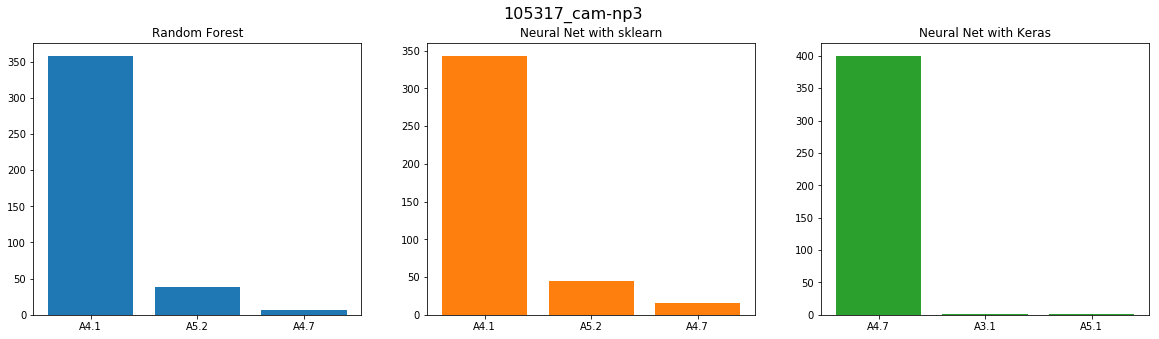

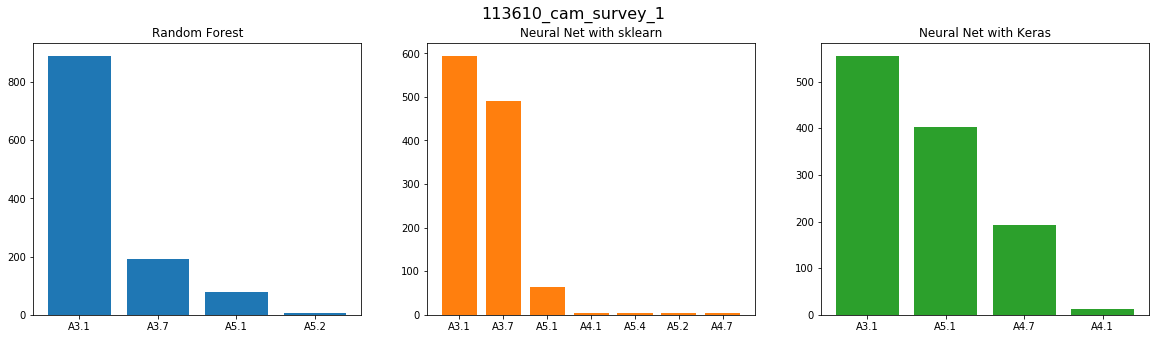

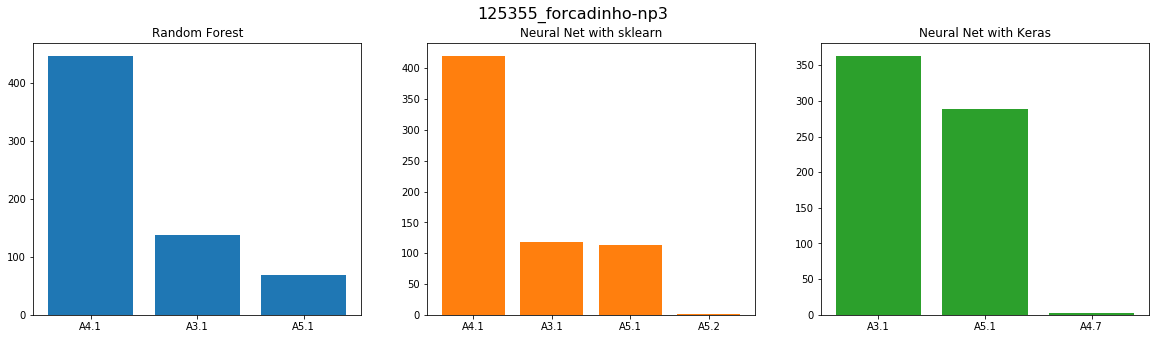

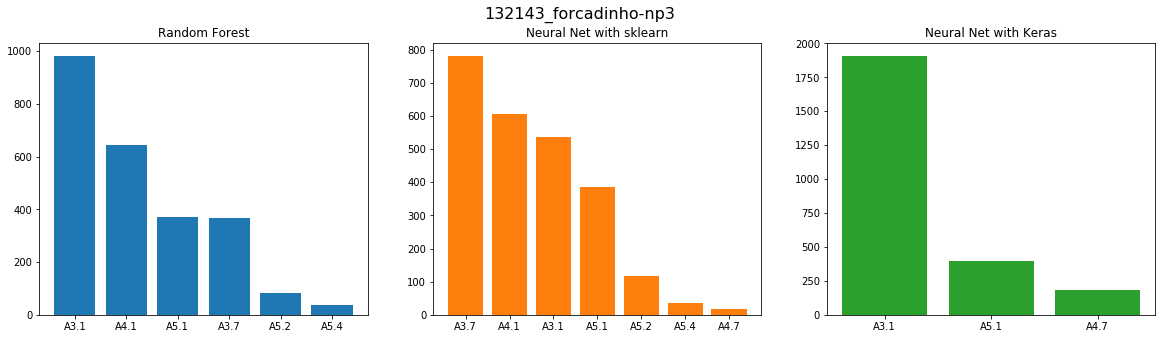

In [259]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.suptitle(folders[1], fontsize=16)
plt.subplot(131)
plt.bar(df1_rf_preds.level3.value_counts().index.tolist(), df1_rf_preds.level3.value_counts())
plt.title('Random Forest')
plt.subplot(132)
plt.bar(df1_nn_preds.level3.value_counts().index.tolist(), df1_nn_preds.level3.value_counts(), color='C1')
plt.title('Neural Net with sklearn')
plt.subplot(133)
plt.bar(df1_keras_preds.level3.value_counts().index.tolist(), df1_keras_preds.level3.value_counts(), color='C2')
plt.title('Neural Net with Keras')

plt.savefig('predictions_' + folders[1] + '.jpg')

plt.figure(figsize=(20,5))
plt.suptitle(folders[2], fontsize=16)
plt.subplot(131)
plt.bar(df2_rf_preds.level3.value_counts().index.tolist(), df2_rf_preds.level3.value_counts())
plt.title('Random Forest')
plt.subplot(132)
plt.bar(df2_nn_preds.level3.value_counts().index.tolist(), df2_nn_preds.level3.value_counts(), color='C1')
plt.title('Neural Net with sklearn')
plt.subplot(133)
plt.bar(df2_keras_preds.level3.value_counts().index.tolist(), df2_keras_preds.level3.value_counts(), color='C2')
plt.title('Neural Net with Keras')

plt.savefig('predictions_' + folders[2] + '.jpg')

plt.figure(figsize=(20,5))
plt.suptitle(folders[3], fontsize=16)
plt.subplot(131)
plt.bar(df3_rf_preds.level3.value_counts().index.tolist(), df3_rf_preds.level3.value_counts())
plt.title('Random Forest')
plt.subplot(132)
plt.bar(df3_nn_preds.level3.value_counts().index.tolist(), df3_nn_preds.level3.value_counts(), color='C1')
plt.title('Neural Net with sklearn')
plt.subplot(133)
plt.bar(df3_keras_preds.level3.value_counts().index.tolist(), df3_keras_preds.level3.value_counts(), color='C2')
plt.title('Neural Net with Keras')

plt.savefig('predictions_' + folders[3] + '.jpg')

plt.figure(figsize=(20,5))
plt.suptitle(folders[4], fontsize=16)
plt.subplot(131)
plt.bar(df4_rf_preds.level3.value_counts().index.tolist(), df4_rf_preds.level3.value_counts())
plt.title('Random Forest')
plt.subplot(132)
plt.bar(df4_nn_preds.level3.value_counts().index.tolist(), df4_nn_preds.level3.value_counts(), color='C1')
plt.title('Neural Net with sklearn')
plt.subplot(133)
plt.bar(df4_keras_preds.level3.value_counts().index.tolist(), df4_keras_preds.level3.value_counts(), color='C2')
plt.title('Neural Net with Keras')

plt.savefig('predictions_' + folders[4] + '.jpg')

Basing on the results we are going to drop the Neural Net built with Keras.
Random Forest looks promising although the Neural Net built with sklearn seems to differentiate better more classifications.